In [1]:
import os
import cv2 as cv
import numpy as np
import utils
from consts import *
from cell_detection_v2 import get_cells
from matplotlib import pyplot as plt
%matplotlib inline

## Moving to the directory and getting list of subdirectories

In [2]:
dir_with_images = 'C:\Programs Python\IOC\Pseudonomas veronii'
os.chdir(dir_with_images)
subdirectories = os.listdir(dir_with_images)

## Getting mask for each image

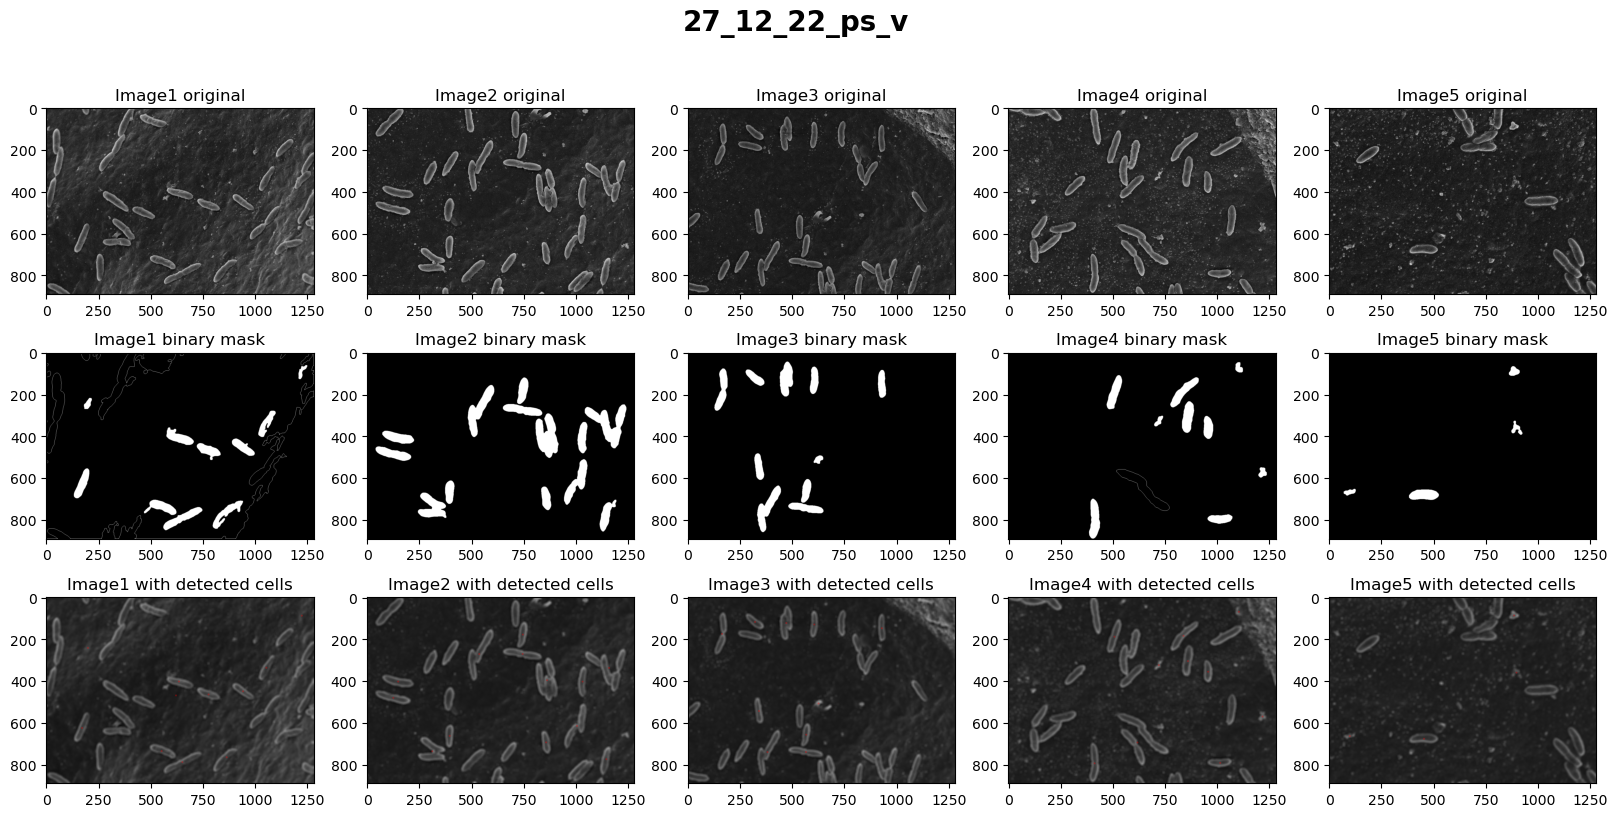

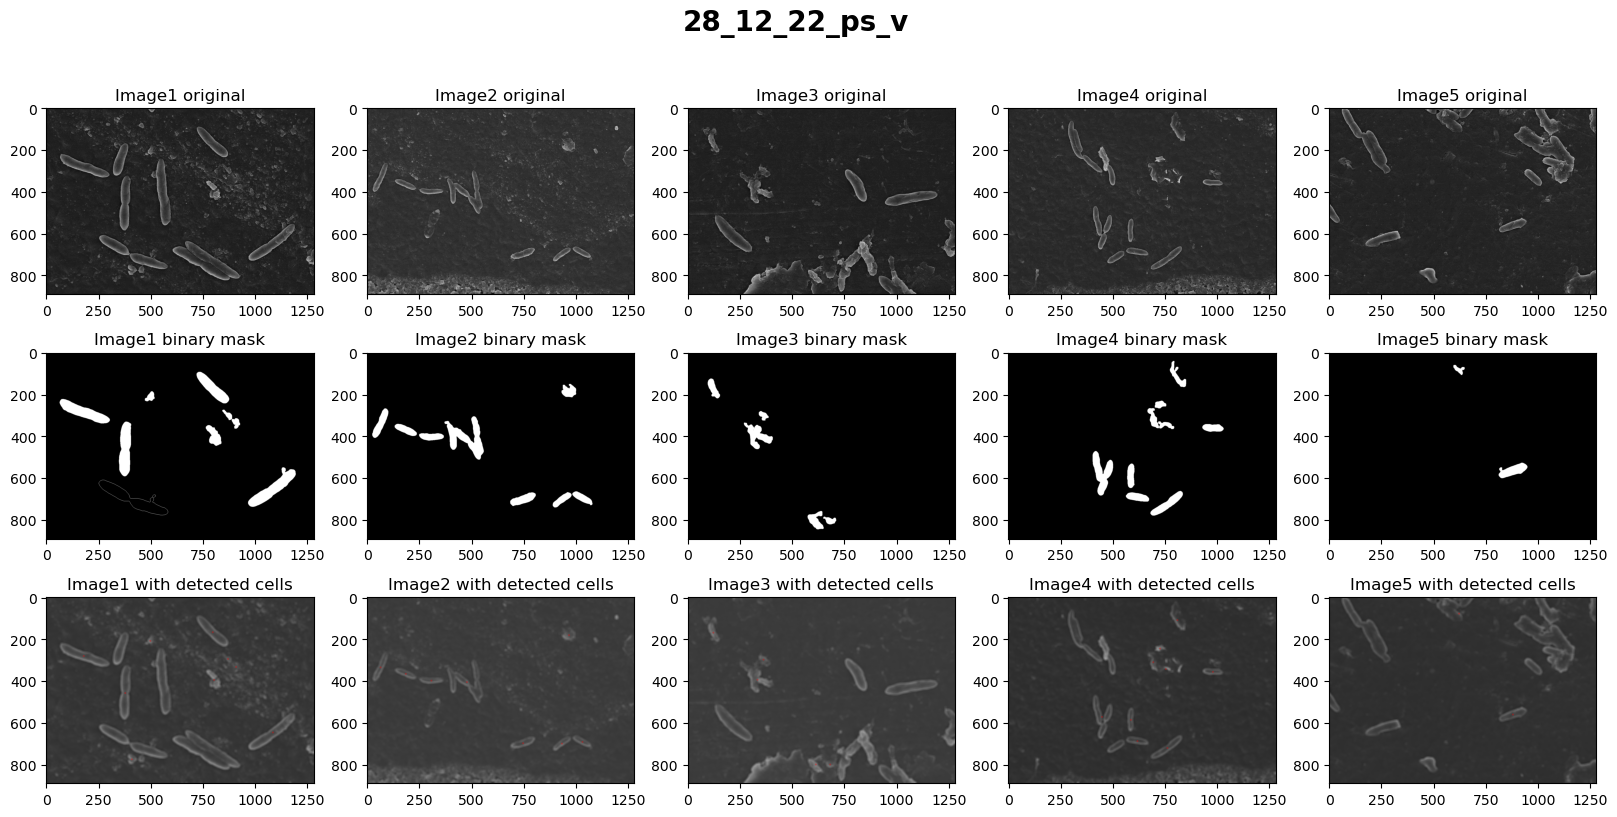

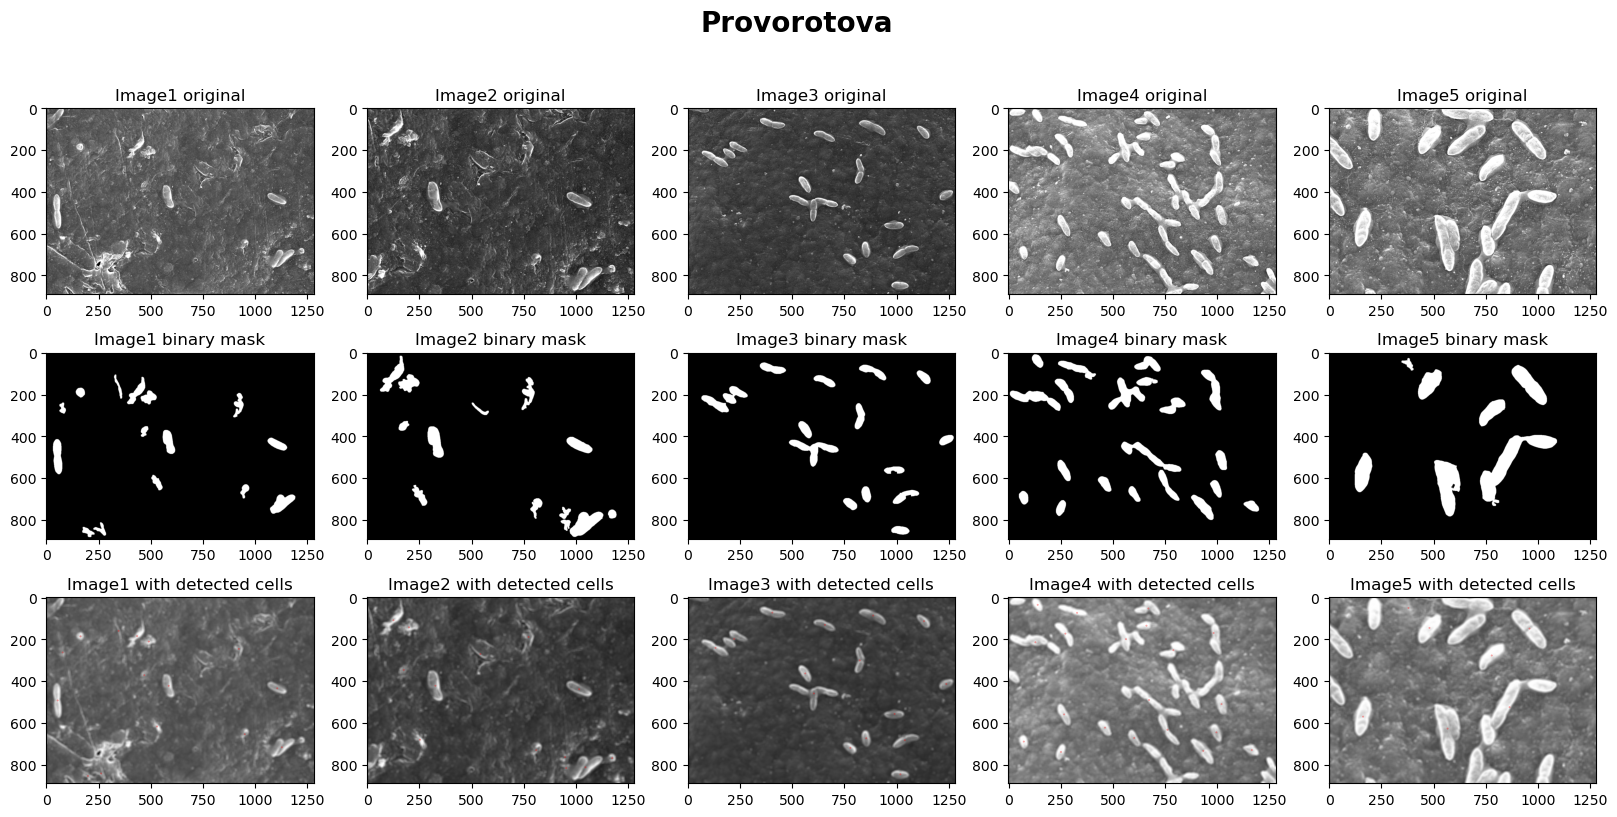

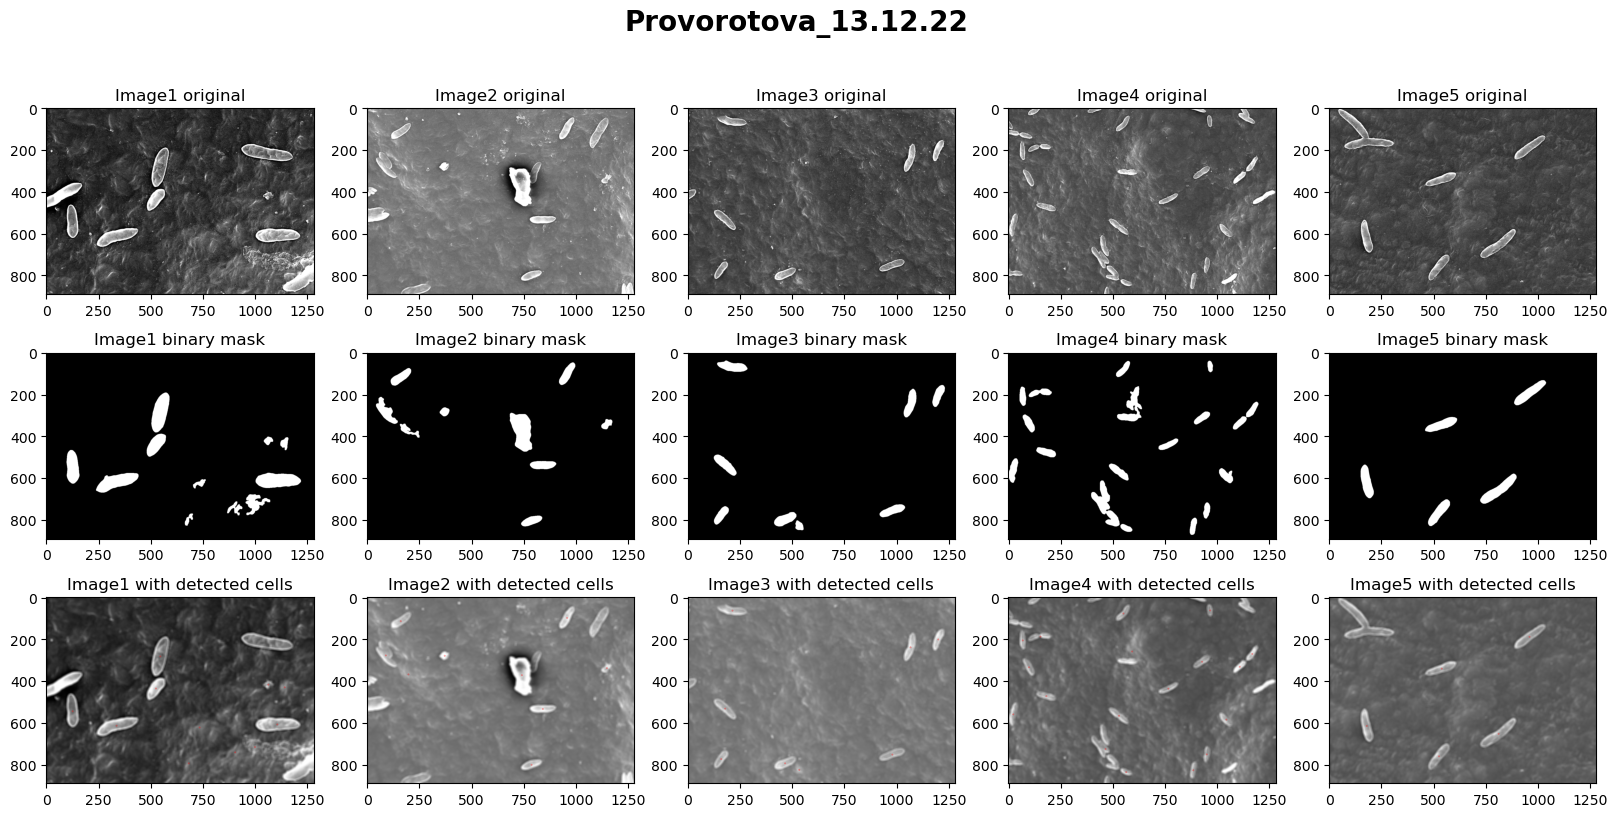

In [3]:
for subdir in subdirectories:
    # get list of images in current directory
    files = os.listdir(subdir)
    os.chdir(subdir)
    images = []
    for file in files:
        image = cv.imread(file, 0)
        image = utils.delete_description(image, utils.get_size_for_crop(image))
        images.append(image)
    os.chdir('..')

    # plot original images and their masks
    fig, axes = plt.subplots(3, 5)
    for j in range(len(images)):
        axes[0, j].imshow(images[j], cmap='gray')
        axes[0, j].set_title(f'Image{j+1} original')

        image_mask, image_detected_cells = get_cells(images[j], Mask_Alg.BLOB_DETECT)
        axes[1, j].imshow(image_mask, cmap='gray')
        axes[1, j].set_title(f'Image{j+1} binary mask')
        axes[2, j].imshow(image_detected_cells, cmap='gray')
        axes[2, j].set_title(f'Image{j+1} with detected cells')
    fig.set_size_inches(20, 9)
    fig.suptitle(subdir, fontsize=20, fontweight='bold')

In [ ]:
path = dir_with_images + '/27_12_22_ps_v'
os.chdir(path)
files = os.listdir(path)

In [ ]:
fig, axes = plt.subplots(5, 4)
for i in range(5):
        image = cv.imread(files[i], 0)
        image = utils.delete_description(image, utils.get_size_for_crop(image))


        # preprocessing: blur and grayscale
        image_blur = utils.filter_image(image, Filter.AVERAGE, average_ksize=12)

        # preprocessing: threshold to get binary inverted image and closing
        ret, image_binary = cv.threshold(image_blur, Color.BLACK.value, Color.WHITE.value,
                                cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
        image_binary = utils.morph_transform(image_binary, Morph.CLOSING)

        full_cnts = np.ones(image_binary.shape, 'uint8')
        contours = cv.findContours(image_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
        contours = [cnt for cnt in contours if cv.contourArea(cnt) > 500]
        cv.drawContours(full_cnts, contours, -1, (255, 255, 255), -1)

        params = cv.SimpleBlobDetector_Params()

        params.filterByArea = True
        params.minArea = 20
        params.maxArea = 1000000

        params.filterByCircularity = True 
        params.minCircularity = 0.2
        params.maxCircularity = 1

        params.filterByConvexity = True
        params.minConvexity = 0.2
        params.maxConvexity = 1

        params.filterByInertia = True
        params.minInertiaRatio = 0.01
        params.maxInertiaRatio = 1

        detector = cv.SimpleBlobDetector_create(params)
        keypoints = detector.detect(full_cnts)

        mask = np.zeros(image_binary.shape, 'uint8') + Color.WHITE.value

        for keypoint in keypoints:
                x_key, y_key = [round(coord) for coord in keypoint.pt]
                size = round(keypoint.size)
                start_x, stop_x = x_key - size, x_key + size + 1
                start_y, stop_y = y_key - size, y_key + size + 1
                mask[start_y:stop_y, start_x:stop_x] = full_cnts[start_y:stop_y, start_x:stop_x]
        mask = 255 - mask

        cnts = np.zeros(image_binary.shape)
        contours = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
        contours = [cnt for cnt in contours if cv.contourArea(cnt) > 1000]
        cv.drawContours(cnts, contours, -1, (255, 255, 255), -1)
        mask = cnts.astype('uint8')

        image_detected_cells = cv.drawKeypoints(image, keypoints, np.array([[0]]),
                                (255, 0, 0))
        cv.drawContours(image_detected_cells, contours, -1, (0, 255, 255), 3)
        

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Image{i+1} original')
        axes[i, 1].imshow(full_cnts, cmap='gray')
        axes[i, 1].set_title(f'Image{i+1} thresh')
        # image_mask, image_detected_cells = get_cells(image, Mask_Alg.BLOB_DETECT)
        axes[i, 2].imshow(mask, cmap='gray')
        axes[i, 2].set_title(f'Image{i+1} binary mask')
        axes[i, 3].imshow(image_detected_cells, cmap='gray')
        axes[i, 3].set_title(f'Image{i+1} with detected cells')
fig.set_size_inches(20, 20)
fig.suptitle(path, fontsize=20, fontweight='bold')

In [ ]:
image = cv.imread(dir_with_images + '/Provorotova/Ps_veronii_i001.tif', 0)
image = utils.delete_description(image, utils.get_size_for_crop(image))

# preprocessing: blur and grayscale
image_blur = utils.filter_image(image, Filter.AVERAGE, average_ksize=12)

# preprocessing: threshold to get binary inverted image and closing
ret, image_binary = cv.threshold(image_blur, Color.BLACK.value, Color.WHITE.value,
                        cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
image_binary = utils.morph_transform(image_binary, Morph.CLOSING)

full_cnts = np.zeros(image_binary.shape, 'uint8') + 255
contours = cv.findContours(image_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
contours = [cnt for cnt in contours if cv.contourArea(cnt) > 500]
# contours_area = list(map(lambda x: cv.contourArea(x), contours)
contours.sort(key=lambda x: cv.contourArea(x), reverse=True)
cv.drawContours(full_cnts, contours, -1, (0, 0, 0), -1)

plt.imshow(full_cnts, cmap='gray', vmin=0, vmax=255)